# Analyzing the Results

Looking at the values summed by state and then a union of all the shapefiles to give a comprehensive overview for all geographies.  

In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import fiona
#import psycopg2
from shapely.geometry import shape, mapping

import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib
from IPython.display import display

import altair as alt
from vega_datasets import data

In [2]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [4]:
vp_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 
    'output', 'voting_power.csv'), dtype={'geoid': 'str'})
display(vp_df.head())

,geoid,state_abbr,office,year,abs_margin,dem_margin,power,voting_power
0,01,AL,president,2016,27.725147,-27.725147,0.418216,0.015084
1,02,AK,president,2016,14.730641,-14.730641,0.139405,0.009464
2,04,AZ,president,2016,3.545595,-3.545595,0.511152,0.144165
3,05,AR,president,2016,26.920978,-26.920978,0.278810,0.010357
4,06,CA,president,2016,30.109293,30.109293,2.555762,0.084883


# State Level Analysis

Summing the voting power values grouped by state.  This is probably the easiest to understand, and most accurate way to summarize the results because the large majority of the power comes from state level races for President and Governor anyways.  

The main takeaways:
* You're making a mistake if you ignore state level races, especially for Governor.
* Roughly 40 percent of state legislature races are uncontested, eroding the power of voters in state level races. 

In [5]:
#https://altair-viz.github.io/gallery/choropleth_repeat.html
states = alt.topo_feature(data.us_10m.url, 'states')

In [6]:
#Look at this:
# Why is this sum of 6.55 so close to the max value of 6.40 for a single florida district?
# I think it's because most of the value comes at the state level for gov, pres, and senate. 
# The remainder of statehouse, ushouse and statesenate don't amount to much even summed.  

data_df = vp_df.copy()
data_df['state_fips'] = data_df['geoid'].str[0:2].astype('int')
data_df = data_df.groupby(by=['state_abbr', 'state_fips']).agg({'voting_power':'sum'})
data_df.reset_index(drop=False, inplace=True)
#data_df.reset_index(inplace=True, drop=True)
display(data_df.sort_values(by='voting_power', ascending=False))

,state_abbr,state_fips,voting_power
9,FL,12,6.551916
27,NC,37,4.105122
22,MI,26,3.660639
38,PA,42,1.575222
30,NH,33,1.523800
48,WI,55,1.192909
10,GA,13,1.001493
43,TX,48,0.680421
4,CA,6,0.521339
23,MN,27,0.513667


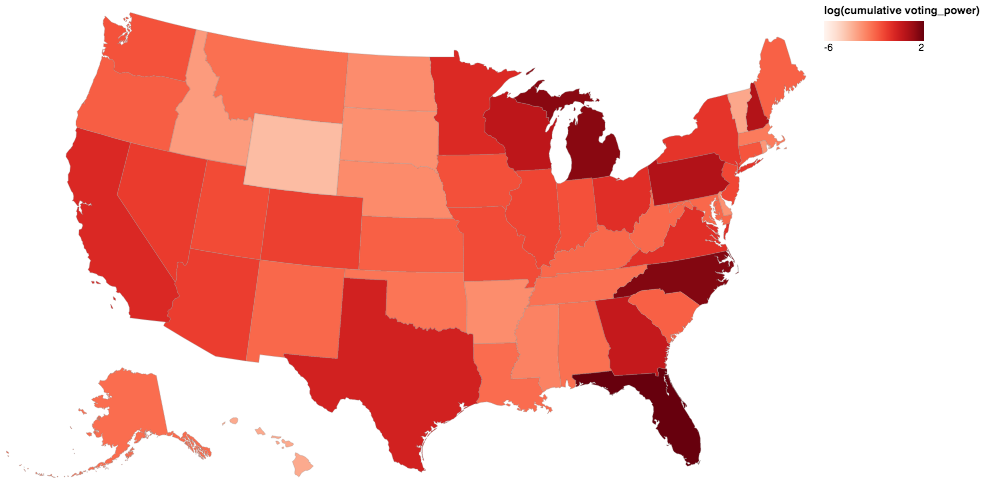

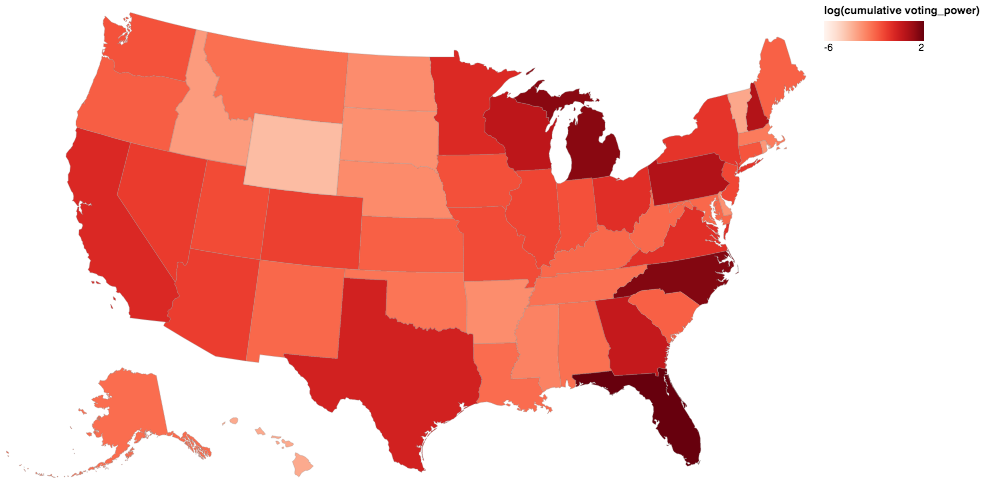

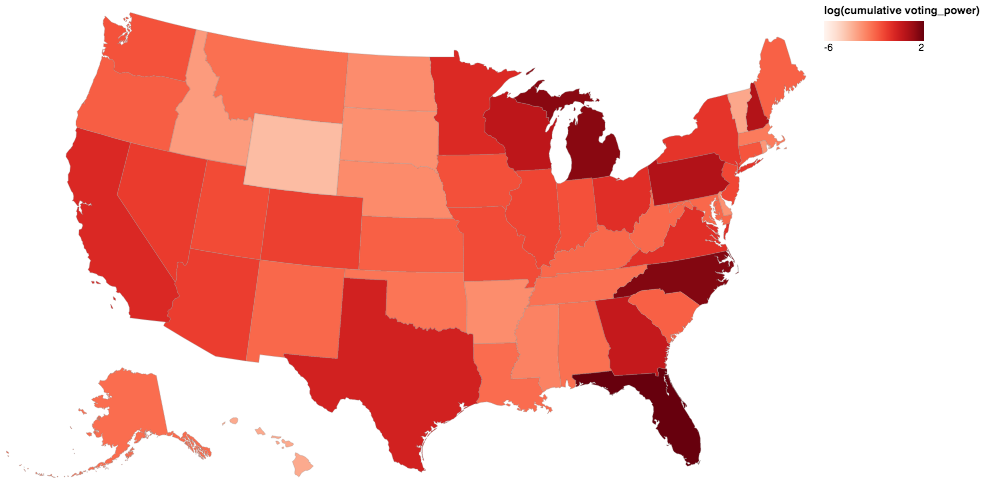

In [7]:
data_df['voting_power'] = np.log(data_df['voting_power'])
w = 800
h = (3/5)*w

mp = alt.Chart(states).mark_geoshape(
    stroke='gray',
    strokeWidth=0.25
).encode(
    alt.Color('voting_power', type='quantitative', 
        scale=alt.Scale(scheme="Reds"),  #type='log', orangered, oranges, reds viridis orangered
        legend=alt.Legend(title="log(cumulative voting_power)")
    )
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(data_df, 'state_fips', ['voting_power']) 
).properties(
    width=w,
    height=h
).project(
    type='albersUsa'
)

display(mp.configure_view(strokeWidth=0))

In [8]:
top_states = data_df.sort_values(by='voting_power', ascending=False)['state_abbr'] #.head(10)['state_abbr']
top_df = vp_df[vp_df.state_abbr.isin(top_states)]

sum_df = top_df.groupby(by='state_abbr').agg({'voting_power':'sum'})
sum_df.rename(columns={'voting_power':'state_power'}, inplace=True)
sum_df.reset_index(inplace=True)

top_df = top_df.groupby(by=['state_abbr', 'office']).agg({'voting_power':'sum', 
     'abs_margin':'min', 'power':'mean'})  #'dem_margin':'mean',
top_df.reset_index(inplace=True)
top_df = top_df.merge(sum_df, on='state_abbr')
top_df = top_df.sort_values(by=['state_power', 'voting_power'], ascending=False)
top_df = top_df[top_df.state_power > 1]
# # Convert to string so not repeated in grouping
# top_df['state_power'] = top_df.state_power.astype('str') 
top_df.set_index(['state_abbr', 'state_power'], inplace=True)
#'dem_margin':'mean_dem_margin'
top_df.rename(columns={'abs_margin':'min_abs_margin'}, inplace=True)
order=['office','power', 'min_abs_margin', 'voting_power']
display(top_df[order])

# Some are driven by closeness across the board, but the top ones are driven
# by either a close governor race, or a close presidential race.  
# Using the min of abs_margin, as the min is responsible for most of the 
# resulting power.  

office     power  min_abs_margin  voting_power
state_abbr state_power                                                     
FL         6.551916        governor  1.627555        0.394900      4.121436
           6.551916       president  1.347584        1.198626      1.124274
           6.551916        ussenate  0.125000        0.122503      1.036689
           6.551916      statehouse  0.006796        0.084434      0.123028
           6.551916         ushouse  0.028736        0.874615      0.111829
           6.551916     statesenate  0.020388        3.258565      0.034659
NC         4.105122        governor  0.793448        0.218148      3.637197
           4.105122       president  0.697026        3.655229      0.190693
           4.105122         ushouse  0.028736        0.320108      0.114202
           4.105122        ussenate  0.125000        1.564446      0.101845
           4.105122      statehouse  0.003313        0.383575      0.037828
           4.105122     statesenate  0.007952        0.890182      0.023357
MI         3.660639       president  0.743494        0.223033      3.333558
           3.660639     statesenate  0.010072        0.075871      0.153072
           3.660639        governor  0.763823        9.567130      0.079838
           3.660639         ushouse  0.028736        3.834388      0.035380
           3.660639      statehouse  0.003479        0.593936      0.030168
           3.660639        ussenate  0.125000        6.505602      0.028623
PA         1.575222       president  0.929368        0.724270      1.283180
           1.575222        ussenate  0.125000        1.432453      0.096975
           1.575222      statehouse  0.002416        0.068476      0.065791
           1.575222        governor  0.978632       17.072299      0.057323
           1.575222         ushouse  0.028736        2.519118      0.049276
           1.575222     statesenate  0.009807        2.724007      0.022677
NH         1.523800        ussenate  0.125000        0.137592      0.947011
           1.523800       president  0.185874        0.367596      0.505647
           1.523800     statesenate  0.002164        0.061277      0.040793
           1.523800        governor  0.103652        7.044083      0.014715
           1.523800      statehouse  0.000130        0.137468      0.010124
           1.523800         ushouse  0.028736        8.551431      0.005511
WI         1.192909       president  0.464684        0.764343      0.607952
           1.192909        governor  0.444235        1.093290      0.406329
           1.192909     statesenate  0.006745        0.070027      0.111116
           1.192909        ussenate  0.125000        3.361977      0.048715
           1.192909         ushouse  0.028736       11.005491      0.010840
           1.192909      statehouse  0.002248        2.667798      0.007957
GA         1.001493        governor  0.803830        1.389146      0.578650
           1.001493         ushouse  0.028736        0.149408      0.231010
           1.001493       president  0.743494        5.131343      0.144893
           1.001493        ussenate  0.125000        7.682710      0.025361
           1.001493      statehouse  0.002238        0.902439      0.013748
           1.001493     statesenate  0.007192        3.847239      0.007831

In [9]:
display(vp_df.groupby(by='office').agg({'dem_margin':'mean', 
    'abs_margin':'mean', 'voting_power': 'sum'}) \
    [['dem_margin', 'abs_margin', 'voting_power']] \
    .sort_values(by='voting_power', ascending=False))

,dem_margin,abs_margin,voting_power
office,,,
governor,-3.274936,14.157078,10.740176
president,-3.674600,18.380372,9.040410
ussenate,-1.019923,21.055863,3.414887
ushouse,7.662104,30.623423,1.702852
statesenate,-6.824567,52.964234,1.048945
statehouse,-4.403811,54.282532,0.949632


In [10]:
def state(o):
    if o in ['governor', 'statesenate', 'statehouse']:
        return 'state'
    return 'federal'

tmp_df = vp_df.copy()
tmp_df['office_type'] = tmp_df['office'].apply(state)
tmp_df.groupby(by='office_type').agg({'dem_margin':'mean', 
    'abs_margin':'mean','voting_power': 'sum'}) \
    .sort_values(by='voting_power', ascending=False)

,abs_margin,voting_power,dem_margin
office_type,,,
federal,27.906667,14.158150,5.119718
state,53.648490,12.738753,-5.029764


# District Level Analysis

Next, I combine all the districts using the [geopandas union function](http://geopandas.org/set_operations.html).  This combines and sums values for all overlapping districts, and creates new polygons for overlapping and non-overlapping areas.

In [11]:
#https://www.reddit.com/r/gis/comments/775imb/accessing_a_gdb_without_esri_arcgis/
db_path_2018 = os.path.join(os.getcwd(), 'data','shapefiles',
    'geodatabase','2018','tlgdb_2018_a_us_legislative.gdb')
layerlist = fiona.listlayers(db_path_2018)
print(layerlist)

['Congressional_Districts_116th', 'State_Legislative_Districts_Upper', 'State_Legislative_Districts_Lower', 'Voting_Districts']


In [12]:
# Prepare data:
st_df = vp_df[vp_df.office.isin(['governor', 'president', 'ussenate'])].copy()
sh_df = vp_df[vp_df.office == 'statehouse'].copy()
ss_df = vp_df[vp_df.office == 'statesenate'].copy()
fh_df = vp_df[vp_df.office == 'ushouse'].copy()
display(fh_df.head())

,geoid,state_abbr,office,year,abs_margin,dem_margin,power,voting_power
151,4811,TX,ushouse,2018,61.699724,-61.699724,0.028736,0.000466
152,1602,ID,ushouse,2018,21.340436,-21.340436,0.028736,0.001347
153,3710,NC,ushouse,2018,18.585477,-18.585477,0.028736,0.001546
154,4004,OK,ushouse,2018,30.062374,-30.062374,0.028736,0.000956
155,3627,NY,ushouse,2018,4.788293,4.788293,0.028736,0.006001


In [13]:
# Prepare Shapes:
fhgeo_df = gpd.read_file(db_path_2018, driver="OpenFileGDB",
    layer='Congressional_Districts_116th')

shgeo_df = gpd.read_file(db_path_2018, driver="OpenFileGDB",
    layer='State_Legislative_Districts_Lower')

ssgeo_df = gpd.read_file(db_path_2018, driver="OpenFileGDB",
    layer='State_Legislative_Districts_Upper')

state_path = os.path.join(os.getcwd(), 'data', 'shapefiles',
    'state', 'tl_2018_us_state', 'tl_2018_us_state.shp')
stgeo_df = gpd.read_file(state_path)

cols = ['GEOID', 'geometry']
renames = {'GEOID':'geoid'}
fhgeo_df = fhgeo_df[cols].rename(columns=renames)
shgeo_df = shgeo_df[cols].rename(columns=renames)
ssgeo_df = ssgeo_df[cols].rename(columns=renames)
stgeo_df = stgeo_df[cols].rename(columns=renames)

# Merge data and shapes together:
# Right join duplicates shared geometries for multi-member districts
fhgeo_df = fhgeo_df.merge(fh_df, on='geoid', how='right')
shgeo_df = shgeo_df.merge(sh_df, on='geoid', how='right') 
ssgeo_df = ssgeo_df.merge(ss_df, on='geoid', how='right')
stgeo_df = stgeo_df.merge(st_df, on='geoid', how='right')
results_df = pd.concat([fhgeo_df, shgeo_df, ssgeo_df, stgeo_df], sort=True)
results_df.reset_index(drop=True, inplace=True)

# OK, there are still ~100 geographies from NH and MD not matching up, but
# I'm not going to worry about it for now.  
# Filter out null geographies:
results_df = results_df[~results_df.geometry.isnull()]
#display(results_df.head())

In [14]:
# First, simplify, then buffer, then round the results at the end.  A different order
# gives a decimal precision that causes problems during the union.
# https://stackoverflow.com/questions/49099049
# And resetting the index somehow helps (https://gis.stackexchange.com/questions/180326/)
# https://gis.stackexchange.com/questions/188622
def around(coords, precision=5):
    result = []
    try:
        return round(coords, precision)
    except TypeError:
        for coord in coords:
            result.append(around(coord, precision))
    return result

def layer_precision(geometry, precision=5):
    geojson = mapping(geometry)
    geojson['coordinates'] = around(geojson['coordinates'], precision)
    return shape(geojson)

results_df.geometry = results_df.geometry.simplify(1e-1, preserve_topology=True)
results_df.geometry = results_df.geometry.buffer(0.1)
results_df['geometry'] =  results_df['geometry'].apply(lambda x: layer_precision(x, precision=2))
results_df.reset_index(inplace=True, drop=True)
display(results_df.head())

,abs_margin,dem_margin,geoid,geometry,office,power,state_abbr,voting_power,year
0,26.379850,-26.379850,0101,"POLYGON ((-88.56 31.69, -88.56 31.7, -88.56 31...",ushouse,0.028736,AL,0.001089,2018
1,22.962472,-22.962472,0102,"POLYGON ((-87.43000000000001 31.16, -87.44 31....",ushouse,0.028736,AL,0.001251,2018
2,27.498868,-27.498868,0103,"POLYGON ((-86.66 33.72, -86.67 33.73, -86.67 3...",ushouse,0.028736,AL,0.001045,2018
3,59.645667,-59.645667,0104,"POLYGON ((-88.28 33.43, -88.29000000000001 33....",ushouse,0.028736,AL,0.000482,2018
4,22.125422,NaN,0105,"POLYGON ((-88.26000000000001 34.93, -88.27 34....",ushouse,0.028736,AL,0.001299,2018


In [15]:
states = list(results_df.state_abbr.drop_duplicates())
# DC won't have any federal or state results, just a presidential result.
# Maybe remove, then add back in at the end when you add the state level data
# But you'll have to add a new row, with shape, for DC when you do.
# Honestly, it's too small to see in the visualization anyways, leave out.
states.remove('DC')
#Apparently needs to be this order for union to work:
offices = ['statehouse', 'statesenate', 'ushouse']  
union_df = pd.DataFrame() 

# To improve performance, only process one state at a time:
for state in states:
    print(state)
    try:
        stateres_df = pd.DataFrame()
        for office in offices:
            temp_df = results_df[(results_df.state_abbr == state) & 
                (results_df.office == office)].copy()
            temp_df = temp_df[['dem_margin', 'voting_power', 'geometry']]
            temp_df.rename(columns={'voting_power': 'voting_power_' + office, 
                'dem_margin':'dem_margin_' + office}, inplace=True)
            if stateres_df.empty:
                stateres_df = temp_df.copy()
            else:
                stateres_df = gpd.overlay(stateres_df, temp_df, how='union', make_valid=True)
                # Round after each union to prevent extra digit buildup 
                stateres_df.geometry.simplify(1e-1, preserve_topology=True)
                #stateres_df['geometry'] =  stateres_df['geometry'].apply(lambda x: layer_precision(x, precision=2))
        stateres_df['state_abbr'] = state
        if union_df.empty:
            union_df = stateres_df.copy()
        else:
            union_df = pd.concat([union_df, stateres_df], sort=True)
    except Exception as e:
        print(e)
        continue

AL
AK
AZ
AR
CA
CO
CT
DE
FL
GA
HI
ID
IL
IN
IA
KS
KY
LA
ME
MD
MA
MI
MN
MS
MO
MT
NE
NV
NH
NJ
NM
NY
NC
ND
OH
OK
OR
PA
RI
SC
SD
TN
TX
UT
VT
VA
WA
WV
WI
WY


In [16]:
# Seperate the state level values out, and merge back onto the
# total union dataframe
cols = ['voting_power', 'dem_margin', 'state_abbr']
gov_df = st_df[st_df.office=='governor'][cols]
gov_df.rename(columns={'voting_power': 'voting_power_governor', 
    'dem_margin':'dem_margin_governor'}, inplace=True)
pres_df = st_df[st_df.office=='president'][cols]
pres_df.rename(columns={'voting_power': 'voting_power_president', 
    'dem_margin':'dem_margin_president'}, inplace=True)
sen_df = st_df[st_df.office=='ussenate'][cols]
sen_df.rename(columns={'voting_power': 'voting_power_ussenate', 
    'dem_margin':'dem_margin_ussenate'}, inplace=True)
# Just take the sum and mean of dem_margin, this will change the 
# final mean dem_margin by a little, but it's the only way.
# The mean will be the mean across every seat, not every election.
sen_df = sen_df.groupby(by='state_abbr') \
    .agg({'voting_power_ussenate':'sum', 'dem_margin_ussenate':'mean'})
sen_df.reset_index(drop=False, inplace=True)

union_df = union_df.merge(gov_df, how='left', on='state_abbr')
union_df = union_df.merge(pres_df, how='left', on='state_abbr')
union_df = union_df.merge(sen_df, how='left', on='state_abbr')

# Sum voting_power, take mean of dem_margin, remove extra columns
margin_cols = [col for col in union_df.columns if 'dem_margin' in col]
power_cols = [col for col in union_df.columns if 'voting_power' in col]
union_df['voting_power'] = union_df[power_cols].sum(axis=1)
union_df['dem_margin'] = union_df[margin_cols].mean(axis=1)
#union_df.drop(columns=margin_cols+power_cols, inplace=True)

# Condense small sliver polygons into nearby polygons that are close
# in voting_power and dem_margin
# Decimals 5: 50k polys, 4: 28k, 3: 10k, 2: 3k
union_df['voting_power'] = union_df.voting_power.round(decimals=2) 
union_df['dem_margin'] = union_df.dem_margin.round(decimals=0)
union_df = union_df.dissolve(by=['voting_power', 'dem_margin', 'state_abbr'],
    aggfunc='mean', as_index=False)
display(union_df.describe())
display(union_df.sort_values(by='voting_power', ascending=False).head(15))

,voting_power,dem_margin,dem_margin_statehouse,dem_margin_statesenate,dem_margin_ushouse,voting_power_statehouse,voting_power_statesenate,voting_power_ushouse,voting_power_governor,dem_margin_governor,voting_power_president,dem_margin_president,voting_power_ussenate,dem_margin_ussenate
count,5085.000000,5085.000000,5058.000000,5032.000000,4756.000000,5059.000000,5032.000000,4966.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000
mean,0.647306,1.076500,0.905375,-1.457798,7.675475,0.001206,0.002659,0.009359,0.328742,-0.042813,0.228211,-1.824290,0.076986,2.396582
std,1.325441,23.547478,54.907809,54.825457,29.873265,0.006766,0.011092,0.024760,0.935354,17.078618,0.554243,18.624038,0.206234,30.259580
min,0.010000,-71.000000,-100.000000,-100.000000,-100.000000,0.000001,0.000006,0.000287,0.001017,-57.128218,0.003046,-45.769510,0.002500,-61.509893
25%,0.070000,-16.000000,-35.825726,-35.024034,-6.584776,0.000033,0.000083,0.000970,0.020344,-8.704395,0.015640,-17.826250,0.010004,-15.008006
50%,0.140000,1.000000,-0.135089,-1.018737,1.801283,0.000080,0.000221,0.001691,0.056777,1.093290,0.054465,-0.764343,0.019805,-2.129603
75%,0.380000,18.000000,39.840623,33.824226,24.783614,0.000203,0.000615,0.004724,0.088233,11.417017,0.144893,13.639387,0.053287,17.336584
max,6.400000,76.000000,100.000000,100.000000,100.000000,0.080490,0.132751,0.192331,4.121436,28.966874,3.333558,31.541091,1.036689,100.000000


,voting_power,dem_margin,state_abbr,geometry,dem_margin_statehouse,dem_margin_statesenate,dem_margin_ushouse,voting_power_statehouse,voting_power_statesenate,voting_power_ushouse,voting_power_governor,dem_margin_governor,voting_power_president,dem_margin_president,voting_power_ussenate,dem_margin_ussenate
5084,6.40,8.0,FL,"POLYGON ((-80.34 25.85, -80.33 25.84, -80.3199...",0.084434,50.483226,0.874615,0.080490,0.000404,0.032855,4.121436,-0.3949,1.124274,-1.198626,1.036689,-3.894388
5083,6.40,0.0,FL,"POLYGON ((-80.34999999999999 25.85, -80.34 25....",0.084434,3.258565,0.874615,0.080490,0.006257,0.032855,4.121436,-0.3949,1.124274,-1.198626,1.036689,-3.894388
5082,6.40,-2.0,FL,"POLYGON ((-80.51000000000001 25.58, -80.52 25....",0.084434,-9.482127,0.874615,0.080490,0.002163,0.032855,4.121436,-0.3949,1.124274,-1.198626,1.036689,-3.894388
5081,6.38,0.0,FL,"POLYGON ((-80.34333333333333 25.85, -80.34 25....",0.084434,3.258565,2.999968,0.080490,0.006257,0.009579,4.121436,-0.3949,1.124274,-1.198626,1.036689,-3.894388
5080,6.37,8.0,FL,"POLYGON ((-80.34 25.85, -80.33 25.84, -80.3199...",0.084434,50.483226,2.999968,0.080490,0.000404,0.009579,4.121436,-0.3949,1.124274,-1.198626,1.036689,-3.894388
5079,6.37,6.0,FL,"POLYGON ((-80.34 25.85, -80.33 25.84, -80.3199...",0.084434,50.483226,-10.453382,0.080490,0.000404,0.002749,4.121436,-0.3949,1.124274,-1.198626,1.036689,-3.894388
5078,6.37,-2.0,FL,"POLYGON ((-80.31 25.83, -80.31 25.82, -80.3 25...",0.084434,-6.296954,-0.363369,0.080490,0.003186,0.007871,4.121436,-0.3949,1.124274,-1.198626,1.036689,-3.894388
5077,6.37,-4.0,FL,POLYGON ((-80.54441176470588 25.68558823529412...,0.084434,-9.482127,-10.453382,0.080490,0.002163,0.002749,4.121436,-0.3949,1.124274,-1.198626,1.036689,-3.894388
5060,6.32,-6.0,FL,"POLYGON ((-80.39 25.59, -80.40000000000001 25....",-22.460306,-9.623594,0.874615,0.000306,0.002129,0.032855,4.121436,-0.3949,1.124274,-1.198626,1.036689,-3.894388
5064,6.32,-2.0,FL,"POLYGON ((-80.40000000000001 25.48, -80.41 25....",-1.244869,-6.296954,0.874615,0.002722,0.003186,0.032855,4.121436,-0.3949,1.124274,-1.198626,1.036689,-3.894388


In [17]:
# fiona.supported_drivers
# {'ARCGEN': 'r',
#  'AeronavFAA': 'r',
#  'BNA': 'raw',
#  'DGN': 'raw',
#  'DXF': 'raw',
#  'ESRI Shapefile': 'raw',
#  'GPKG': 'rw',
#  'GPSTrackMaker': 'raw',
#  'GPX': 'raw',
#  'GeoJSON': 'rw',
#  'Idrisi': 'r',
#  'MapInfo File': 'raw',
#  'OpenFileGDB': 'r',
#  'PCIDSK': 'r',
#  'SEGY': 'r',
#  'SUA': 'r'}
# Output these results as shapefile:
# Clips column names, but at least it writes
# out_path = os.path.join(os.getcwd(), 'data', 'output', 'voting_power.shp')
# union_df.to_file(driver='ESRI Shapefile', filename=out_path)
# Geopackage won't work with multipolygons:
# out_path = os.path.join(os.getcwd(), 'data', 'output', 'voting_power.gpkg')
# union_df.to_file(driver='GPKG', filename=out_path)
# Geodatabase also has
# out_path = os.path.join(os.getcwd(), 'data', 'output', 'voting_power.gdb')
# union_df.to_file(driver='FileGDB', filename=out_path)
# GeoJSON works best I guess: 
# out_path = os.path.join(os.getcwd(), 'data', 'output', 'voting_power.json')
# union_df.to_file(driver='GeoJSON', filename=out_path)
# Output as pickle so you can import without re-running analysis
pickle_path = os.path.join(os.getcwd(), 'data', 'output', 'voting_power.pkl')
union_df.to_pickle(pickle_path)

# Map the Results

In [ ]:
# Import pickle to avoid re-running analysis:
# pickle_path = os.path.join(os.getcwd(), 'data', 'output', 'voting_power.pkl')
# union_df = pd.read_pickle(pickle_path)
# union_df.head()

In [18]:
state_path = os.path.join(os.getcwd(), 'data', 'shapefiles',
    'state', 'tl_2018_us_state', 'tl_2018_us_state.shp')
state_outlines_df = gpd.read_file(state_path)
state_outlines_df = state_outlines_df[~(state_outlines_df['GEOID'] \
    .str[0:2].isin(['02', '15', '60', '66', '69', '72', '78']))]
state_outlines_df = state_outlines_df.to_crs({'init': 'EPSG:5070'})

In [19]:
temp_df = union_df[['voting_power', 'dem_margin', 'geometry', 'state_abbr']].copy()
temp_df = temp_df[~temp_df.state_abbr.isin(['AK', 'HI'])]
temp_df['log_voting_power'] = np.log(temp_df['voting_power'])
temp_df = temp_df.to_crs({'init': 'EPSG:5070'})

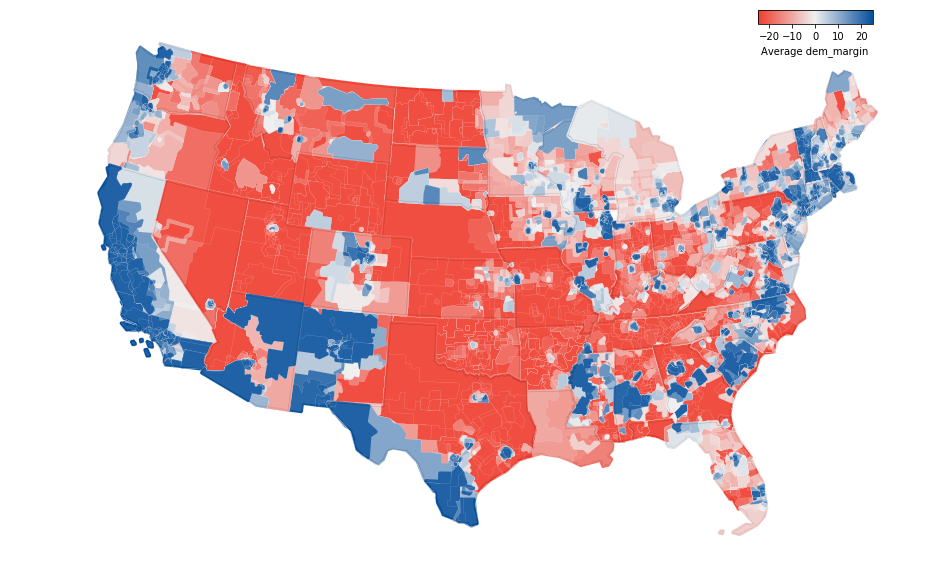

In [25]:
def add_colorbar(fig, data_df, column, cmap, label):
    # https://stackoverflow.com/questions/53158096
    vmin = data_df[column].min()
    vmax = data_df[column].max()
    cax = fig.add_axes([0.7, 0.87, 0.08, 0.02])  # [left, bottom, width, height] 
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    #ticks = [int(vmin), int(vmax)]
    cbr = fig.colorbar(sm, cax=cax, label=label, orientation='horizontal') #ticks=ticks
    return fig

#.clip(lower=-50.0, upper=50.0)
temp_df['dem_margin_clip'] = temp_df['dem_margin'].clip(lower=-25.0, upper=25.0)
# Construct colormap using midpoint:
cmap = clr.LinearSegmentedColormap.from_list('red_blue', 
    [(0, '#EF3B2C'), (0.5, '#EFEFEF'), (1,'#08519C')], N=256)

fig, ax = plt.subplots(figsize=(20,10))
ax.axis('off')
temp_df.plot(ax=ax, column='dem_margin_clip', cmap=cmap, edgecolor='white', linewidth=0.1)
state_outlines_df.plot(ax=ax, edgecolor='black', alpha=0.1, facecolor='white', linewidth=0.5)
fig = add_colorbar(fig, temp_df, 'dem_margin_clip', cmap, 'Average dem_margin')
plt.show()

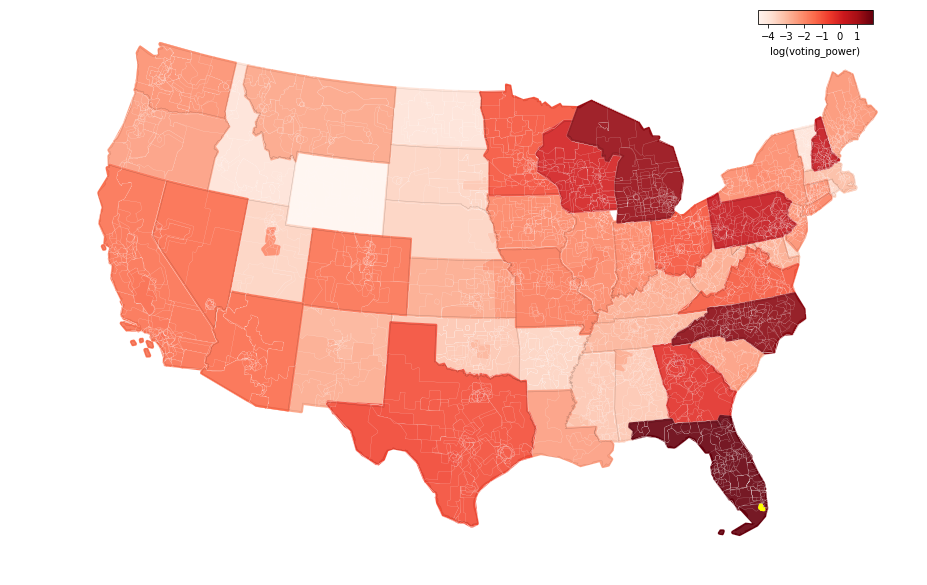

In [23]:
fig, ax = plt.subplots(figsize=(20,10))
ax.axis('off')
temp_df.plot(ax=ax, column='log_voting_power', cmap='Reds', edgecolor='white',linewidth=0.12)
state_outlines_df.plot(ax=ax, edgecolor='black', alpha=0.1, facecolor='white', linewidth=0.5)
temp_df.sort_values(by='voting_power', ascending=False).head(10).plot(ax=ax, color='yellow')
fig = add_colorbar(fig, temp_df, 'log_voting_power', 'Reds', 'log(voting_power)')
plt.show()

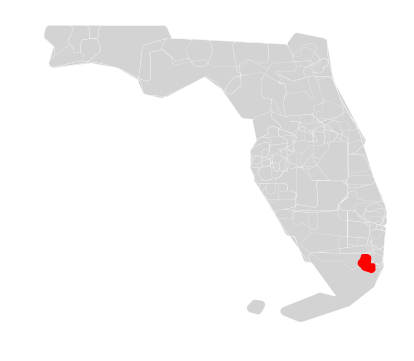

In [108]:
fig, ax = plt.subplots(figsize=(13,6))
ax.axis('off')
union_df[union_df.state_abbr == 'FL'].plot(ax=ax, color='lightgray',edgecolor='white',linewidth=0.2)
union_df.sort_values(by='voting_power', ascending=False).head(10).plot(ax=ax, color='red')
plt.show()

In [70]:
# Output for folium map:
# https://blog.dominodatalab.com/creating-interactive-crime-maps-with-folium/
# folium_df = temp_df.to_crs({'init': 'crs:84'})
# folium_df = union_df[['voting_power', 'dem_margin', 'geometry', 'state_abbr']].copy()
# folium_df = folium_df[~folium_df.state_abbr.isin(['AK', 'HI'])]
# folium_df['log_voting_power'] = np.log(folium_df['voting_power'])
# folium_path = os.path.join(os.getcwd(), 'data', 'output', 'folium_map.json')
# folium_df.to_file(driver='GeoJSON', filename=folium_path)

# Not performant enough for large geojson files.  
# import folium
# Create Interactive Map
# http://python-visualization.github.io/folium/quickstart.html#Getting-Started
# map_1 = folium.Map(location=[39, -96], zoom_start=4)
# # vpi_series = county2016_df.set_index('fips_code')['county_vpi']

# folium.geo_json(
#     open('./data/output/folium_map.json').read(),
# #     columns = ['log_voting_power'],
# #     fill_color = 'YlOrRd', 
# #     legend_name = 'Number of incidents per district'
# )  #.add_to(map_1)
# map_1

## Adventures in PostgisLand

In [20]:
# The geopandas union above is pretty computationally 
# intensive for my computer, so I tried PostGIS.
# I couldn't get the union query below to return 
# non garbled shapes, so I'm not using it for now.
# I may return to it in the future if I need to.  

# If you don't have postgres or postgis installed
# these are the steps if you use brew on a mac:
# $ brew update
# $ brew install postgresql
# $ brew install postgis

# Also, set your user password:
# https://serverfault.com/questions/110154

# Bash commands to create the database and add extension, only run once:
# ! createdb -U psthomas voting_power
# ! psql -U psthomas -d voting_power -c "CREATE EXTENSION postgis"

In [33]:
# In advance at command line:
# $ export POSTGRESPASS = '<your-postgres-pass>'
pw = os.environ['POSTGRESPASS'] 
connection = psycopg2.connect(database="voting_power", user="psthomas", password=pw)
cursor = connection.cursor()
# Note that if below you have a failed transaction, you need to rerun this to
# reconnect to the database with a new connection without the broken transaction.
# https://stackoverflow.com/questions/10399727

In [29]:
# Following this example: http://andrewgaidus.com/Build_Query_Spatial_Database/
# And using the union query described here: https://gis.stackexchange.com/questions/83
cursor.execute('''DROP TABLE IF EXISTS power;''')

# id SERIAL PRIMARY KEY,
cursor.execute('''
    CREATE TABLE power (
    abs_margin DOUBLE PRECISION,
    dem_margin DOUBLE PRECISION,
    geoid VARCHAR,
    geometry GEOGRAPHY, 
    office VARCHAR,
    power DOUBLE PRECISION,
    state_abbr VARCHAR,
    voting_power DOUBLE PRECISION,
    year BIGINT
    );
''')

cursor.execute('''
    CREATE INDEX geometry_index
    ON power
    USING GIST(geometry);
''')

connection.commit()

In [30]:
# Add the results_df data
cursor.execute("DELETE FROM power")

# The dtypes for these need to be define on table definition above
# https://postgis.net/docs/ST_GeomFromText.html
for row in results_df.itertuples(index=False):
    cursor.execute('''
        INSERT INTO power (abs_margin, dem_margin, geoid, geometry,
        office, power, state_abbr, voting_power, year)
        VALUES (%s, %s, %s, ST_GeogFromText(%s), %s, %s, %s, %s, %s);
    ''', (row.abs_margin, row.dem_margin, row.geoid, str(row.geometry),
    row.office, row.power, row.state_abbr, row.voting_power, row.year))
    
connection.commit() 

In [ ]:
# Create the polygon overlay, equivalent to Geopandas Union
# https://gis.stackexchange.com/questions/83
# Modified to cast geometry, which is a geography type, as a geometry type:
# https://gis.stackexchange.com/questions/91184

cursor.execute('''
    CREATE TABLE my_poly_overlay AS
    SELECT geom FROM ST_Dump((
        SELECT ST_Polygonize(the_geom) AS the_geom FROM (
            SELECT ST_Union(the_geom) AS the_geom FROM (
                SELECT ST_ExteriorRing(geometry::geometry) AS the_geom FROM power) AS lines
            ) AS noded_lines
        )
    )
''')
connection.commit()

In [ ]:
# Rejoin with data based on those that intersect, right outer join, sum by geography.  
# Then get the results back using the geopandas from_postgis function
# https://stackoverflow.com/questions/36732075/geopandas-postgis-connection
# and plot/table the results. 

# https://stackoverflow.com/questions/36732075
sql = 'SELECT * FROM my_poly_overlay'
poly_df = gpd.GeoDataFrame.from_postgis(sql, connection, geom_col='geom' )

fig, ax = plt.subplots(figsize=(20,10))
poly_df.plot(ax=ax, k=3, linewidth=0.1)
ax.set_xlim([-120, -68])
ax.set_ylim([25, 50])
plt.show()